<a href="https://www.kaggle.com/code/valentindefour/richter-predictor-nepalese-earthquake-damages?scriptVersionId=94066230" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

I am very attached to Nepal as I did a great travel there back in the days. When I was there, hanging out in Kathmandu, I could see the damages of the 2015 earthquake and all the efforts put in to rebuild the city.

This dataset and classification problem come from DrivenData.org, a platform which hosts data science competition for the social good. Don't hesitate to check them out, they host great projects !

Link of the competition : https://www.drivendata.org/competitions/57/nepal-earthquake

# IMPORTING USEFUL LIBRARIES

In [1]:
import numpy as np
import pandas as pd

import pprint

import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn import ensemble, tree, linear_model, svm, naive_bayes, neural_network, neighbors

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

#allows to, among other functionnalities,print head and info of a df in the same cell 
from IPython.display import display_html 

# LOADING DATA

In [10]:
train = pd.read_csv('./data/train_values.csv')
target = pd.read_csv('./data//train_labels.csv')
test = pd.read_csv('./data/test_values.csv')
ss = pd.read_csv('./data/submission_format.csv')

In [4]:
train = pd.merge(train, target, on = 'building_id', how = 'left')
train.set_index('building_id', drop = True, inplace = True)
test.set_index('building_id', drop = True, inplace = True)

In [5]:
train.head()
train.info()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

We have a total of 37 parameters, mostly numerical values, with a few of them being string values. We'll transform these strings to numerical / categorical values further.

# Problem description

We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake.

**There are 3 grades of the damage:**
1. represents low damage
1. represents a medium amount of damage
1. represents almost complete destruction

# Performance metric

We are predicting the level of damage from 1 to 3. The level of damage is an ordinal variable meaning that ordering is important. This can be viewed as a classification or an ordinal regression problem. (Ordinal regression is sometimes described as an problem somewhere in between classification and regression.)

To measure the performance of our algorithms, we'll use the F1 score which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score.

# Few vizualizations to discover the data we have to work with

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


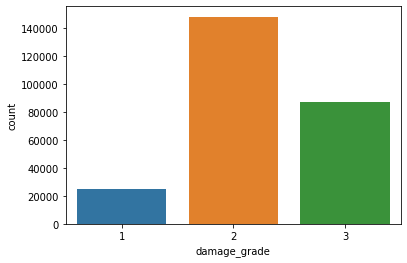

In [6]:
sb.countplot(train['damage_grade'])
print(train['damage_grade'].value_counts())

We can note that damage_grade = 2 is much more representated than 1 and about twice more than 3. Let's investigate more, using the geo_level as another variable : according to the host of the competition, the 'geo level' data represents the geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Let's see what does it mean on results :

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='geo_level_1_id'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='geo_level_2_id'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='geo_level_3_id'>

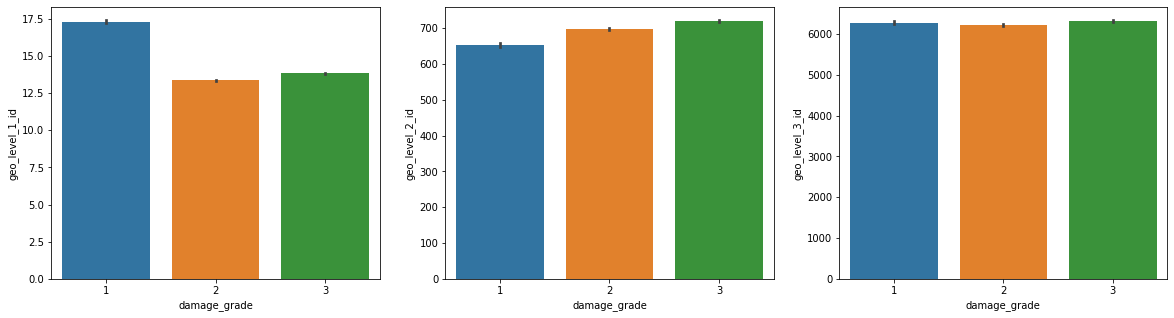

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sb.barplot(train['damage_grade'], train['geo_level_1_id'])

plt.subplot(1,3,2)
sb.barplot(train['damage_grade'], train['geo_level_2_id'])

plt.subplot(1,3,3)
sb.barplot(train['damage_grade'], train['geo_level_3_id'])

plt.show()

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age'>

<AxesSubplot:>

(array([1.34644e+05, 8.52860e+04, 2.45600e+04, 7.22200e+03, 5.40100e+03,
        1.57400e+03, 2.31000e+02, 1.55000e+02, 1.90000e+01, 1.19000e+02]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <BarContainer object of 10 artists>)

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='age'>

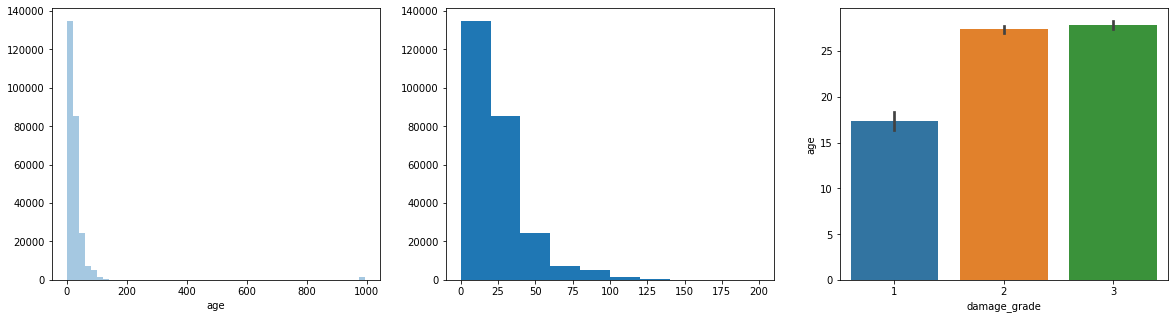

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sb.distplot(train['age'], kde = False)

plt.subplot(1,3,2)
plt.hist(train['age'], range=(0,200))

plt.subplot(1,3,3)
sb.barplot(train['damage_grade'],train['age'])

Building are almost all above 100 years of age. For each damage grade, only a few are a thousand years old. With no suprise, newer buildings where less damaged.

Let's now look at height / area percentage and floor data :

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='height_percentage'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='area_percentage'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='count_floors_pre_eq'>

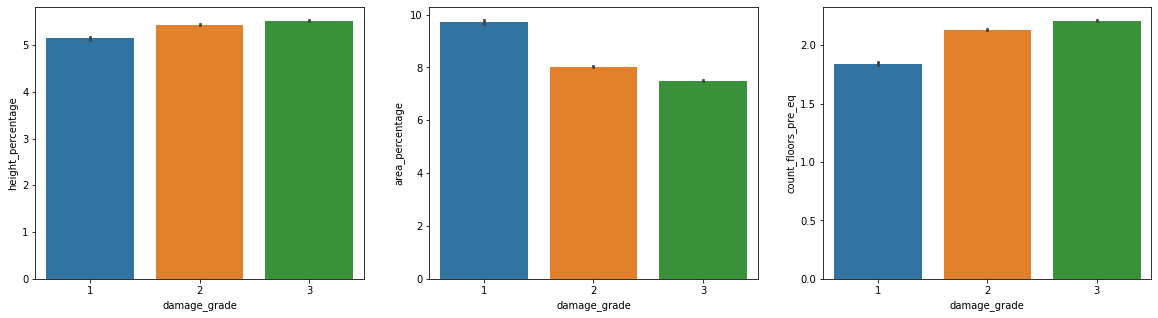

In [9]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sb.barplot(train['damage_grade'], train['height_percentage'])

plt.subplot(1,3,2)
sb.barplot(train['damage_grade'], train['area_percentage'])

plt.subplot(1,3,3)
sb.barplot(train['damage_grade'], train['count_floors_pre_eq'])

We can see a sligh correlation between the height/area data and the damage grade level. Plus, higher buildings tend to get more damaged.

What about the 'superstructure' data ?

<Figure size 2160x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

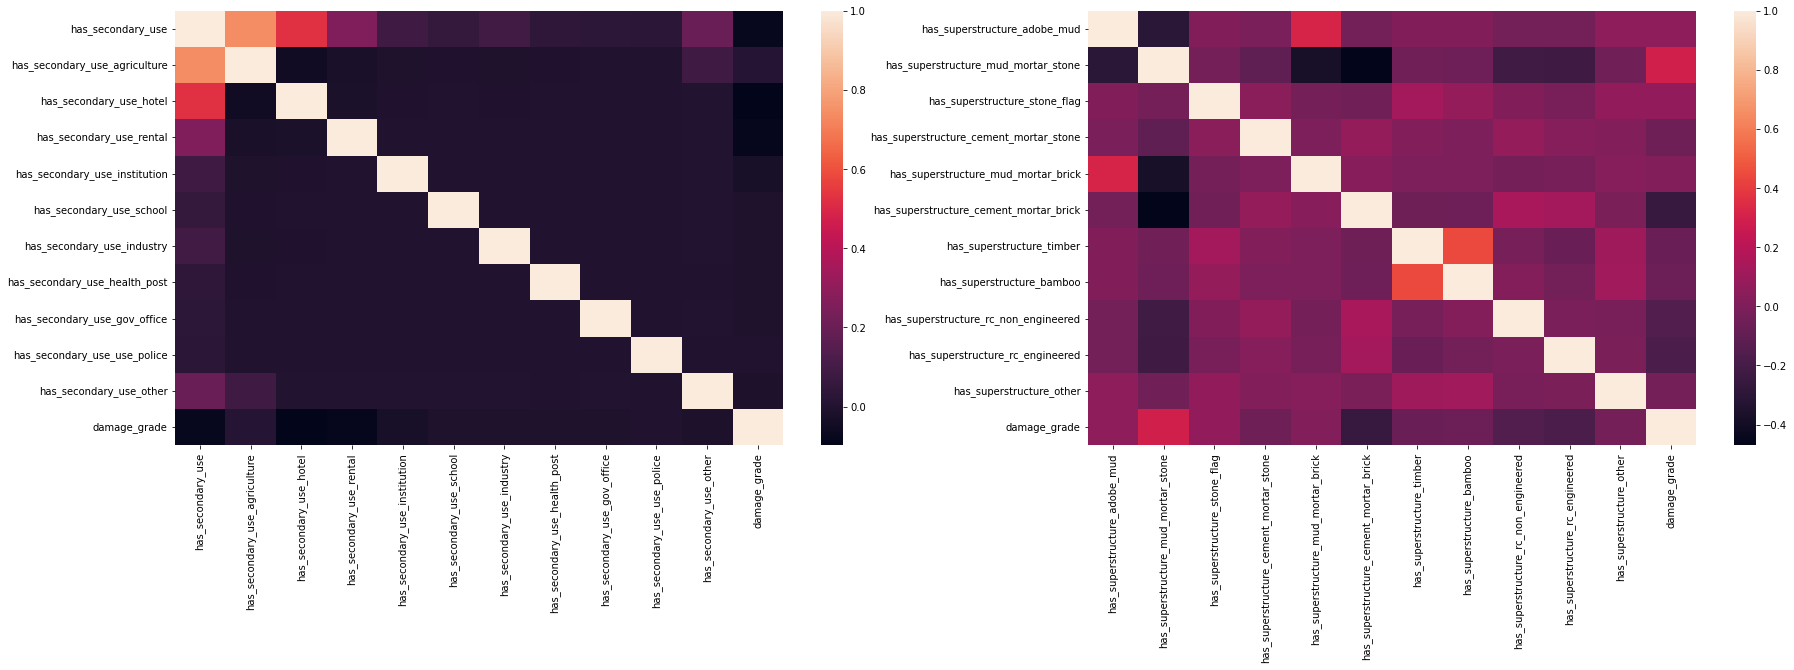

In [10]:
superstructure_cols = [x for x in train.columns if 'super' in x]
secondary_use_cols = [x for x in train.columns if 'secondary' in x]

superstructure_corr = train[superstructure_cols+['damage_grade']].corr()
secondary_use_corr = train[secondary_use_cols+['damage_grade']].corr()

plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
sb.heatmap(secondary_use_corr)

plt.subplot(1,2,2)
sb.heatmap(superstructure_corr)

Correlation between damages and secondary_use is weak but we can see that there might be something interesting with superstructures :

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='has_superstructure_adobe_mud'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='has_superstructure_mud_mortar_stone'>

<AxesSubplot:>

c:\Users\Valentin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='has_superstructure_cement_mortar_brick'>

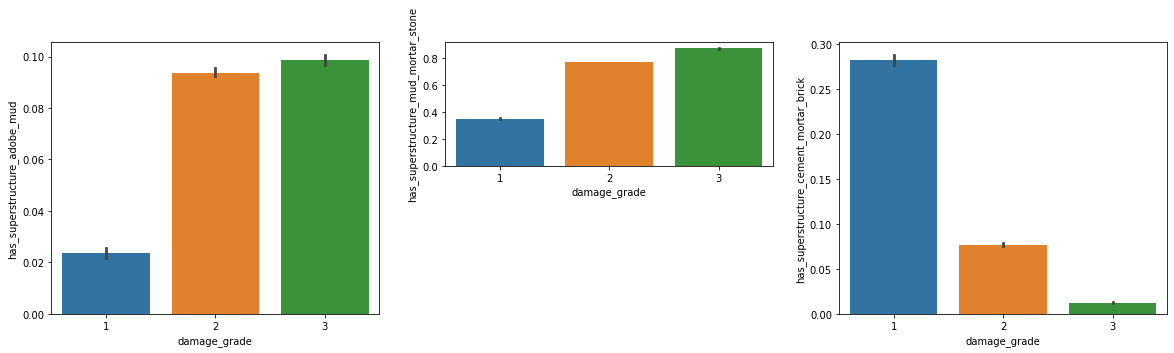

In [11]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sb.barplot(train['damage_grade'], train['has_superstructure_adobe_mud'])

plt.subplot(2,3,2)
sb.barplot(train['damage_grade'], train['has_superstructure_mud_mortar_stone'])

plt.subplot(1,3,3)
sb.barplot(train['damage_grade'], train['has_superstructure_cement_mortar_brick'])

We can clearly see that mud structures were much more damaged than more solid ones like cement.

From now, we'll move to data preparation and a first modeling approach.

# Data preparation (split, cleaning, ...)

Treating categorical data with pandas 'get_dummies' function.

In [12]:
text_features = []
for column in train.columns:
    if train[column].dtype == 'object':
        text_features.append(column)

for feature in text_features:
    train = train.join(pd.get_dummies(train[feature], prefix = feature))
    test = test.join(pd.get_dummies(test[feature], prefix = feature))
    
    train.drop(feature, axis = 1, inplace = True)
    test.drop(feature, axis = 1, inplace = True)


features = train.drop('damage_grade', axis = 1).columns

In [13]:
train.head()
train.shape

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,...,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,0,0,0,0,1,0


(260601, 69)

Our train dataset is ready for train/test split :

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train.damage_grade, random_state = 42)

We will fit the train data to common classifiers to see which one of these performs better on a first approach :

In [15]:
classifiers = [neighbors.KNeighborsClassifier(),
               tree.DecisionTreeClassifier(),
               ensemble.RandomForestClassifier(),
               ensemble.GradientBoostingClassifier(),
               xgb.XGBClassifier()]

def test_models(classifiers):
    
    for model in classifiers:
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        
        print(model)
        score = f1_score(Y_test, Y_pred, average='micro')
        print(score)
        print('############')
        
test_models(classifiers)

KNeighborsClassifier()
0.7035041672422526
############
DecisionTreeClassifier()
0.6576261300670749
############
RandomForestClassifier()
0.7110098079845283
############
GradientBoostingClassifier()
0.6809872450154257
############


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]

Looks like RandomForest and XGBoost performs pretty well and both give a f1 score which will get you a minima of top 20% in the competition.

But I am sure we can do better than that. Let's try to tune both of these results by performing feature engineering and parameters optimization.

# Feature engineering

Let's dive into some changes / removals we could perform on our features to get a better result.

First, let's re-train our 2 best base-models and compare their confusion matrices :

In [16]:
rf_clf = ensemble.RandomForestClassifier()
xgb_clf = xgb.XGBClassifier()

rf_clf.fit(X_train, Y_train)
y_pred_rf = rf_clf.predict(X_test)

xgb_clf.fit(X_train, Y_train)
y_pred_xgb = xgb_clf.predict(X_test)

RandomForestClassifier()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [1 2 3]

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

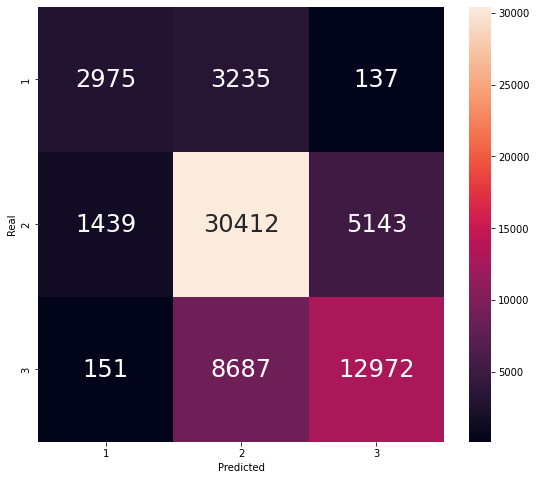

In [17]:
df_cm_rf = pd.DataFrame(confusion_matrix(Y_test, y_pred_rf), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm_rf.index.name = 'Real'
df_cm_rf.columns.name = 'Predicted'

# df_cm_xgb = pd.DataFrame(confusion_matrix(Y_test, y_pred_xgb), columns=np.unique(Y_test), index = np.unique(Y_test))
# df_cm_xgb.index.name = 'Real'
# df_cm_xgb.columns.name = 'Predicted'

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sb.heatmap(df_cm_rf, annot=True, fmt='d', annot_kws={"size": 24})

# plt.subplot(1,2,2)
# sb.heatmap(df_cm_xgb, annot=True, fmt='d', annot_kws={"size": 24})

Both of our models over-estimate the damage_grade level 2 (42300 / 43813 predicted for 36994 real), which is almost + 15%.

On the other hand, they tend to under-estimate both damage_grade levels 1 and 3.

Let's look at the classification reports for both of our models :

In [18]:
print("Random Forest")
print(classification_report(Y_test, y_pred_rf))
# print('############################################################')
# print("XG Boost")
# print(classification_report(Y_test, y_pred_xgb))

Random Forest
              precision    recall  f1-score   support

           1       0.65      0.47      0.55      6347
           2       0.72      0.82      0.77     36994
           3       0.71      0.59      0.65     21810

    accuracy                           0.71     65151
   macro avg       0.69      0.63      0.65     65151
weighted avg       0.71      0.71      0.71     65151



These classification reports show that the prediction for damage_grade = 1 isn't really good, which can appear as a predictible result, looking at the damage_grade repartition in the training set seen before.

In [18]:
importance_rf = pd.DataFrame({"Features":features, "Importance_RF":rf_clf.feature_importances_}).sort_values(by='Importance_RF', ascending = False).head(15)
importance_xgb = pd.DataFrame({"Features":features, "Importance_XGB":xgb_clf.feature_importances_}).sort_values(by='Importance_XGB', ascending = False).head(15)

RF_styler = importance_rf.style.set_table_attributes("style='display:inline'").set_caption('Top 15 Random Forest importance')
XGB_styler = importance_xgb.style.set_table_attributes("style='display:inline'").set_caption('Top 15 XGBoost importance')

display_html(RF_styler._repr_html_()+XGB_styler._repr_html_(), raw=True)

,Features,Importance_RF
2,geo_level_3_id,0.154505
1,geo_level_2_id,0.136489
0,geo_level_1_id,0.133538
4,age,0.121801
5,area_percentage,0.110667
6,height_percentage,0.056216
18,count_families,0.024683
3,count_floors_pre_eq,0.016352
35,foundation_type_r,0.015294
8,has_superstructure_mud_mortar_stone,0.014327


We see here that, for the Random Forest, the geographical data is unmissable for our model. On the other hand, for XGBoost, categorical data look like to have more influence.

Let's just check that 'foundation_type_r' feature, which has a high importance for XGB :

1    219196
0     41405
Name: foundation_type_r, dtype: int64

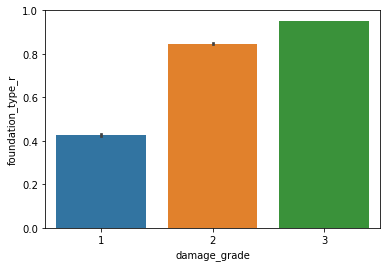

In [19]:
train['foundation_type_r'].value_counts()
sb.barplot(train['damage_grade'], train['foundation_type_r'])

This feature seems to be important to predict an output of damage_grade=3.

Let's now see if we find outliers in other numerical values :

<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, 'geo_level_1_id')

Text(0.5, 0, 'geo_level_2_id')

Text(0.5, 0, 'geo_level_3_id')

Text(0.5, 0, 'age')

Text(0.5, 0, 'area_percentage')

Text(0.5, 0, 'height_percentage')

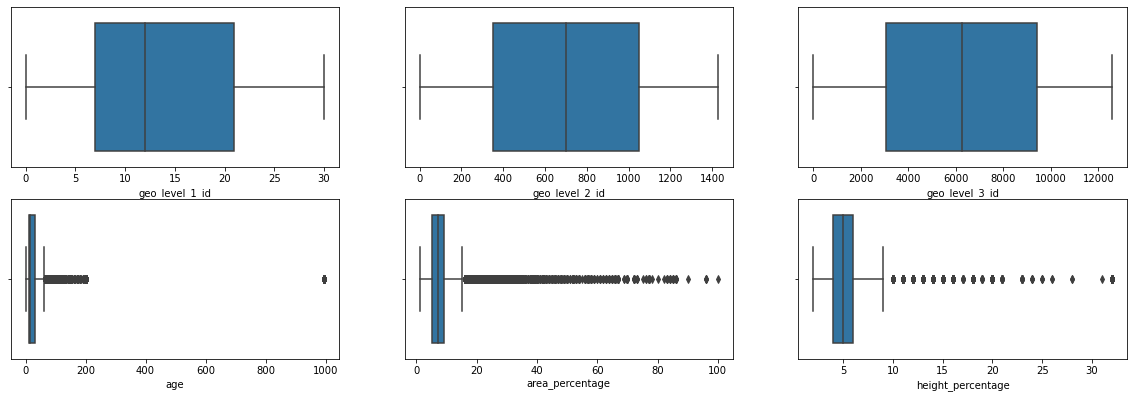

In [20]:
num_features = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','age','area_percentage','height_percentage']
i = 1

plt.figure(figsize=(20,10))

for col in num_features:
    plt.subplot(3,3,i)
    ax=sb.boxplot(train[col].dropna())
    plt.xlabel(col)
    i+=1
plt.show()

# TUNING XGBOOST CLF

Let's take back our base-xgboost classifier perform a few tuning manipulations on its parameters :

In [21]:
print('Baseline f1 score :')
print(f1_score(Y_test, y_pred_xgb, average='micro'))
print('Parameters associated :')
xgb_clf.get_params

Baseline f1 score :
0.7279243603321515
Parameters associated :


<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

In [22]:
param_1 = {'max_depth' : [10, 20, 40, 60, 80]}

xgb_gs = GridSearchCV(xgb_clf, param_1, n_jobs=-1,verbose=2, scoring='f1_micro', cv=3)

xgb_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 81.6min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                      

# MAKING THE SUBMISSION

In [23]:
def make_submission(test_data, classifier):
    
    classifier.fit(X_train, Y_train)
    
    test_data['damage_grade'] = classifier.predict(test_data[features])

    test_data['damage_grade'].to_csv('submission.csv', index = True)

In [24]:
make_submission(test, xgb_gs)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 81.8min finished


# TESTING AUTO ML APPROACH

In [3]:
import h2o        
from h2o.automl import H2OAutoML

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,34 mins 34 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_valen_41z7vi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.965 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [13]:
train_h2o = h2o.H2OFrame(pd.concat([train, target.drop('building_id', axis = 1)], axis = 1))
test_h2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
train_h2o

building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,2
728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1
441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1


In [15]:
train, test = train_h2o.split_frame(ratios = [0.75])

x = train.columns
y = 'damage_grade'
x.remove(y)

In [16]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20,
                max_runtime_secs=120,
                seed=69)

%time aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
20:06:03.25: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
CPU times: total: 344 ms
Wall time: 2min 51s


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,70.0,70.0,9349565.0,17.0,17.0,16.27143,1.0,20977.0,10630.586
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-08-25 20:06:56,9.633 sec,0.0,0.6104516,0.5073572,0.3726511,0.6127342,0.5104782,0.3754432
,2023-08-25 20:06:56,10.412 sec,5.0,0.5218105,0.4405728,0.2722862,0.5496643,0.4627589,0.3021309
,2023-08-25 20:06:57,11.101 sec,10.0,0.4579161,0.3864963,0.2096871,0.5044895,0.4257861,0.2545097
,2023-08-25 20:06:58,11.759 sec,15.0,0.4266254,0.3611983,0.1820093,0.4905128,0.4154292,0.2406028
,2023-08-25 20:06:59,12.599 sec,20.0,0.3924155,0.3282211,0.1539899,0.4778060,0.4011161,0.2282986
,2023-08-25 20:06:59,13.206 sec,25.0,0.3743527,0.3095661,0.1401399,0.4699272,0.3912807,0.2208316
,2023-08-25 20:07:00,13.772 sec,30.0,0.3583813,0.2910794,0.1284372,0.4634583,0.3810720,0.2147936
,2023-08-25 20:07:01,14.645 sec,35.0,0.3371389,0.2690879,0.1136627,0.4593212,0.3733906,0.2109759


In [17]:
preds = aml.leader.predict(test_h2o)
preds = preds.cbind(test_h2o)
preds

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
2.58901,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2.10389,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2.02271,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1.5464,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
2.65081,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2.14649,871976,22,170,4029,1,55,4,3,t,r,q,f,j,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1.45493,691228,26,432,6794,2,0,6,7,n,r,n,v,x,s,d,0,0,0,0,0,1,0,0,0,0,1,v,1,0,0,0,0,0,0,0,0,0,0,0
3.05899,896100,8,1373,958,2,35,2,8,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,0,0,0,0,0,0,0,0,0,0,0,0
2.18182,343471,16,244,3521,2,30,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2.03061,766647,26,761,3137,2,5,6,7,n,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
submission_df = preds[['building_id','predict']]
submission_df.set_names(['building_id', 'damage_grade'])

building_id,damage_grade
300051,2.58901
99355,2.10389
890251,2.02271
745817,1.5464
421793,2.65081
871976,2.14649
691228,1.45493
896100,3.05899
343471,2.18182
766647,2.03061


In [27]:
submission_df = submission_df.as_data_frame(use_pandas=True, header=True)
submission_df['damage_grade'] = submission_df['damage_grade'].astype('int')
submission_df.head()

,building_id,damage_grade
0,300051,2
1,99355,2
2,890251,2
3,745817,1
4,421793,2


In [28]:
submission_df.to_csv('submission_auto_ml.csv', index=False)

Thanks for reading. Do not hesitate to comment if you have questions about the competition or my notebook. I will regularly update this with better classifiers in order to gain, I hope, a few ranks up. :D

Remarks about what I could do better are greatly appreciated !